In [1]:
import torch
from torch import nn,optim
from torch.autograd import Variable
from torch.nn import init
from matplotlib import pyplot as plot
import pandas as pd
import numpy as np

## Reading Data

In [2]:
csvfile = pd.read_csv("../steering.csv")

In [3]:
print(csvfile.head(10))

             timestamp     angle  torque      speed
0  1479424214787219361  0.003491  0.1250  22.880556
1  1479424214807231859  0.003491  0.1250  22.886110
2  1479424214827300730  0.003491  0.1250  22.891666
3  1479424214847355643  0.003491  0.1875  22.897223
4  1479424214867355824  0.003491  0.0000  22.902779
5  1479424214887364135  0.003491  0.0625  22.905556
6  1479424214907399816  0.003491  0.2500  22.908333
7  1479424214927455132  0.003491 -0.0625  22.911112
8  1479424214947476806  0.001745  0.0000  22.913889
9  1479424214967638631  0.001745 -0.0625  22.913889


## Display the original angle

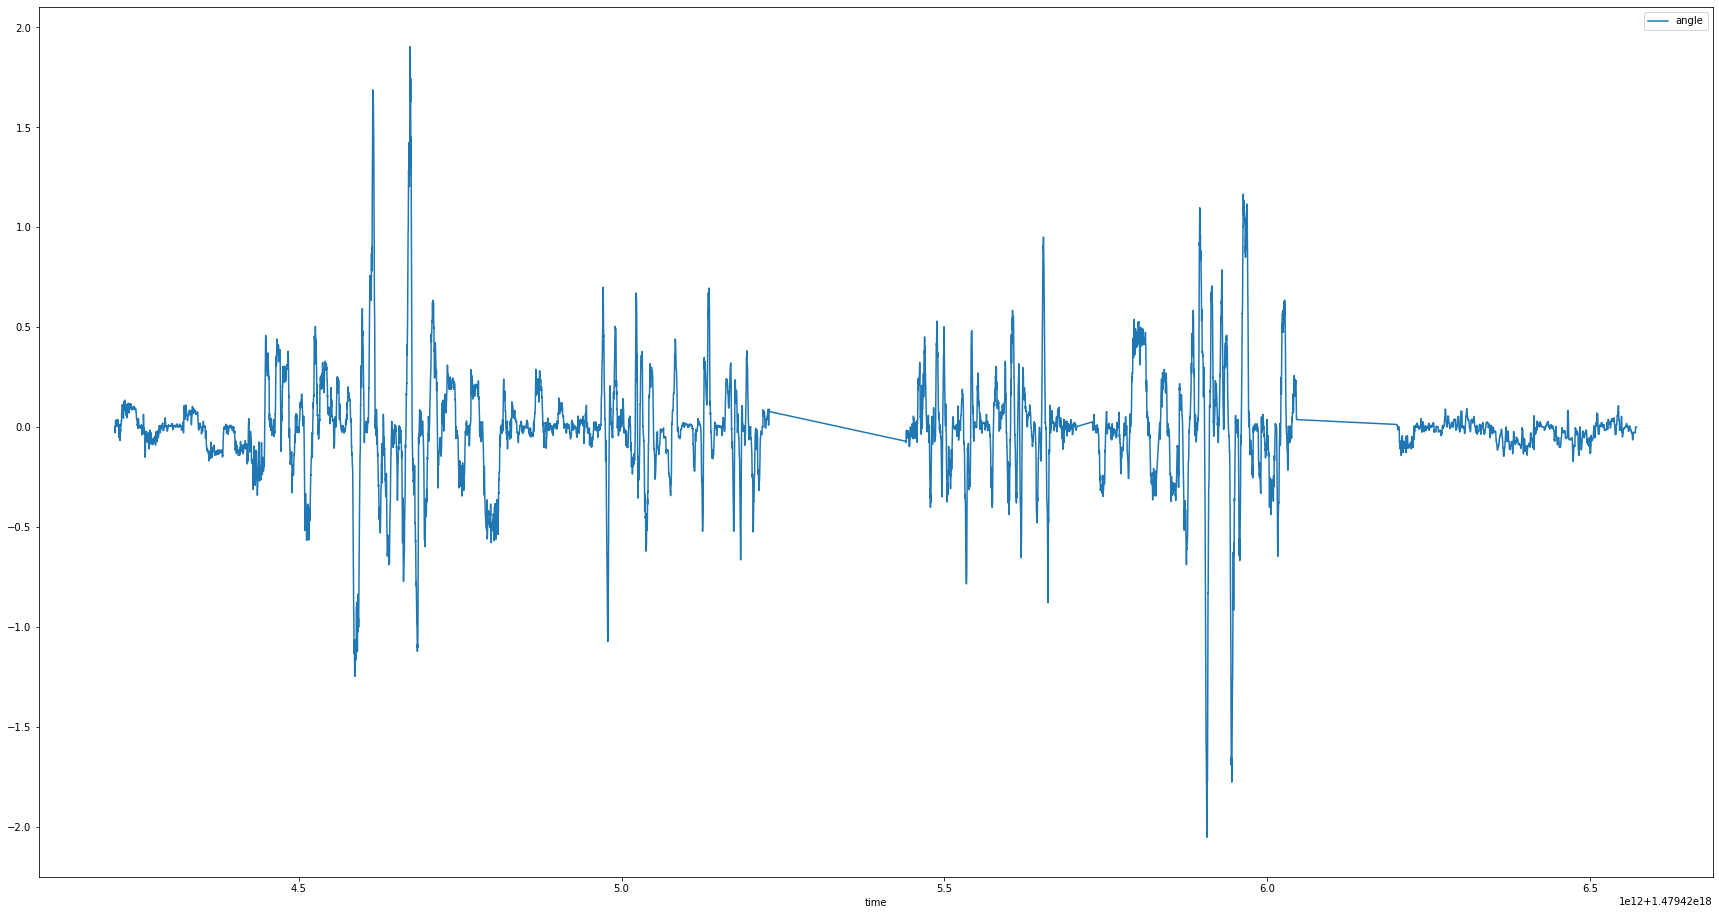

In [4]:
plot.figure(figsize=(30,16))
plot.plot(csvfile.timestamp, csvfile.angle,label='angle')
plot.xlabel("time")
plot.legend()

## Processing Data

In [5]:
angle = csvfile.angle
nums = len(angle)
data = np.array(angle)
data = data.reshape(97887,1)

In [6]:
train_num = nums * 8 //10
train_data = data[0:train_num-1]
train_label = data[1:train_num]

In [7]:
test_data = data[train_num:nums-1]
test_label = data[train_num+1: nums]

## Model

In [8]:
class rnnModel(nn.Module):
    def __init__(self,in_dim,hidden_dim,out_dim,layer_num):
        super().__init__()
        self.fcLayer=nn.Linear(hidden_dim,out_dim)
        self.lstm = nn.LSTM(in_dim, hidden_dim, layer_num)

    def forward(self, x):
        out,_=self.lstm(x)
        out=self.fcLayer(out)
        return  out

    def weightInit(self,gain=1):
        for name ,param in self.named_parameters():
            if 'rnnLayer.weight' in name:
                init.orthogonal(param,gain)


## One sample Training and Testing

In [9]:
rnn_one=rnnModel(1,20,1,10)
rnn_one = rnn_one.cuda()
criterion_one=nn.MSELoss()
criterion_one = criterion_one.cuda()
optimizer_one=optim.Adam(rnn_one.parameters(),lr=1e-3)
epoches = 5


# Train
for i in range(0, epoches):
    
    #initialize
    initial_data = torch.from_numpy(train_data[0].astype(np.float32)).reshape(1,1,1)
    inputs = initial_data
    outputs_train = []
    loss_train = []
    for e in range(0, len(train_data)) :
        
        # forward
        inputs = Variable(inputs)
        inputs = inputs.cuda()
        output = rnn_one(inputs)
        if e % 249 == 0:
            inputs = torch.from_numpy(train_data[e].astype(np.float32)).reshape(1,1,1)
        else:
            inputs = output
        
        # loss backforward and optimize
        target = Variable(torch.from_numpy(train_label[e].astype(np.float32)).reshape(1,1,1))
        target = target.cuda()
        loss = criterion_one(output, target)
        optimizer_one.zero_grad()
        loss.backward()
        optimizer_one.step()
        
        loss_train.append(loss.cpu().item())
        outputs_train.append(output.cpu().item())
        
    print('Epoch [{}/{}],train_loss = {:.10f}'.format(i,epoches, np.mean(loss_train)))
    
#Test       
    
#initialize
initial_data = torch.from_numpy(test_data[0].astype(np.float32)).reshape(1,1,1)
inputs = initial_data
outputs_test = []
loss_test = []
rnn_one.eval()
with torch.no_grad():
    for e in range(0, len(test_data)):
        #forward
        inputs = Variable(inputs)
        inputs = inputs.cuda()
        output = rnn_one(inputs)
        outputs_test.append(output.cpu().item())
        if e % 249 == 0:
            inputs = torch.from_numpy(test_data[e].astype(np.float32)).reshape(1,1,1)
        else:
            inputs = output

        #calculate loss
        target = Variable(torch.from_numpy(test_label[e].astype(np.float32)).reshape(1,1,1))
        target = target.cuda()
        loss = criterion_one(output, target)
        loss_test.append(loss.cpu().item())
    print('test_loss = {:.10f}'.format(np.mean(loss_test)))     

Epoch [0/5],train_loss = 0.0058246513
Epoch [1/5],train_loss = 0.0063410989
Epoch [2/5],train_loss = 0.0040041883
Epoch [3/5],train_loss = 0.0029662251
Epoch [4/5],train_loss = 0.0023131876
test_loss = 0.2988731736


## Training graph of Predicted Data and Ground Truth

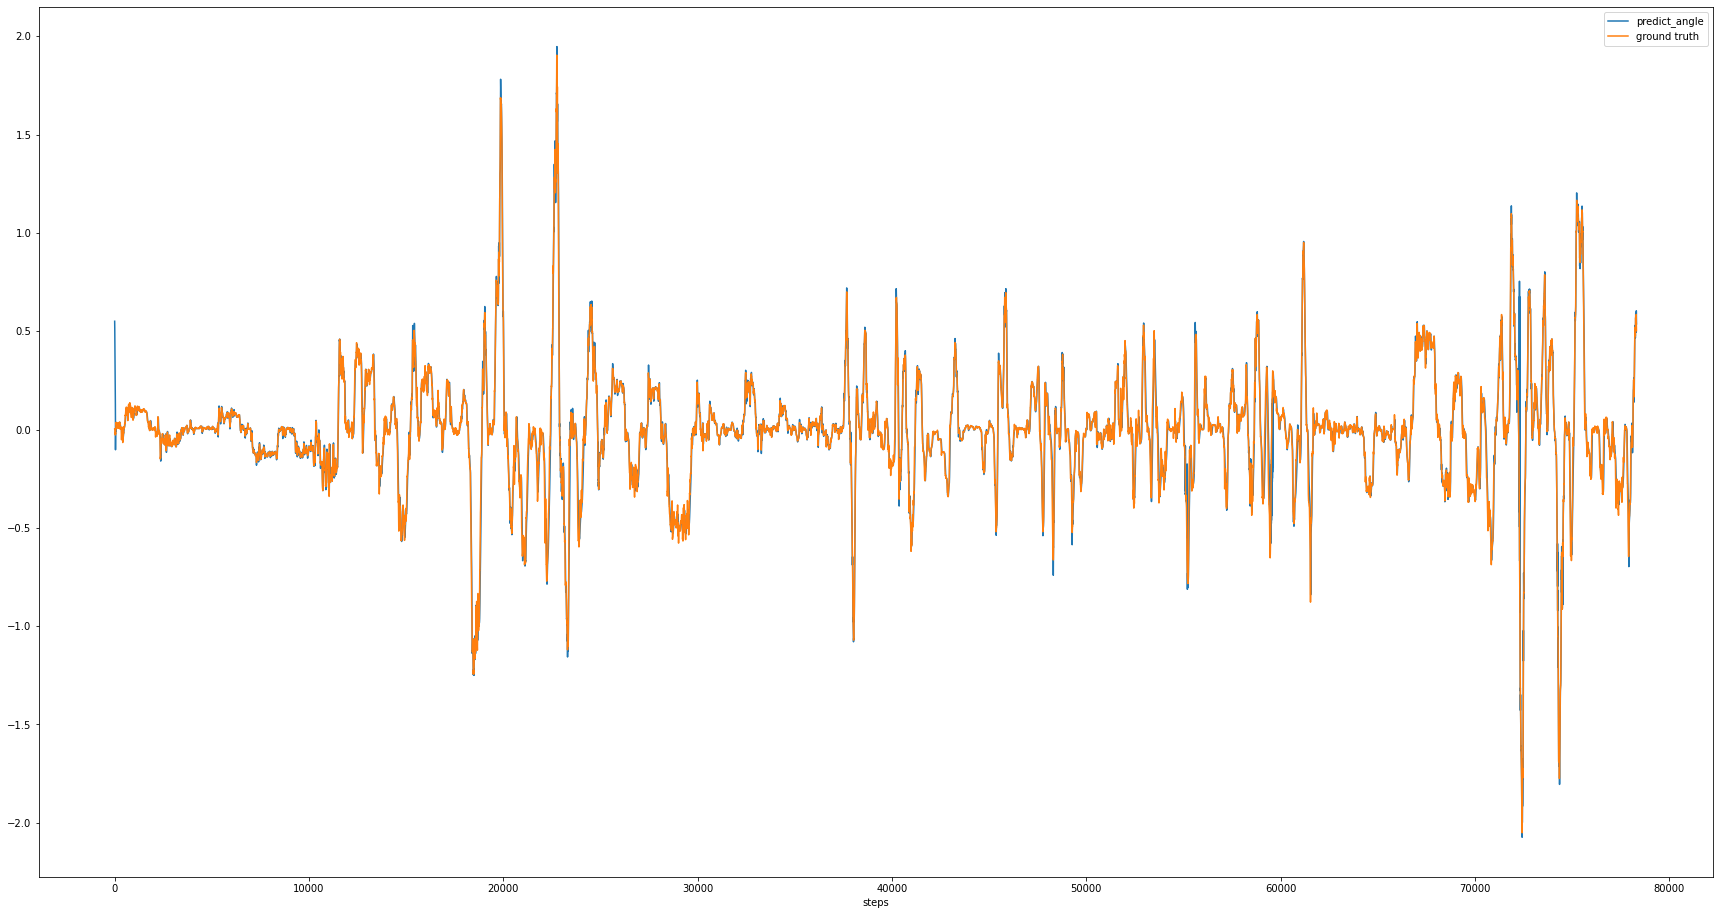

In [10]:
plot.figure(figsize=(30,16))
plot.plot(range(0,len(outputs_train)), outputs_train,label='predict_angle')
plot.plot(range(0,len(outputs_train)), train_label,label='ground truth')
plot.xlabel("steps")

plot.legend()

## Testing graph of Predicted Data and Ground Truth

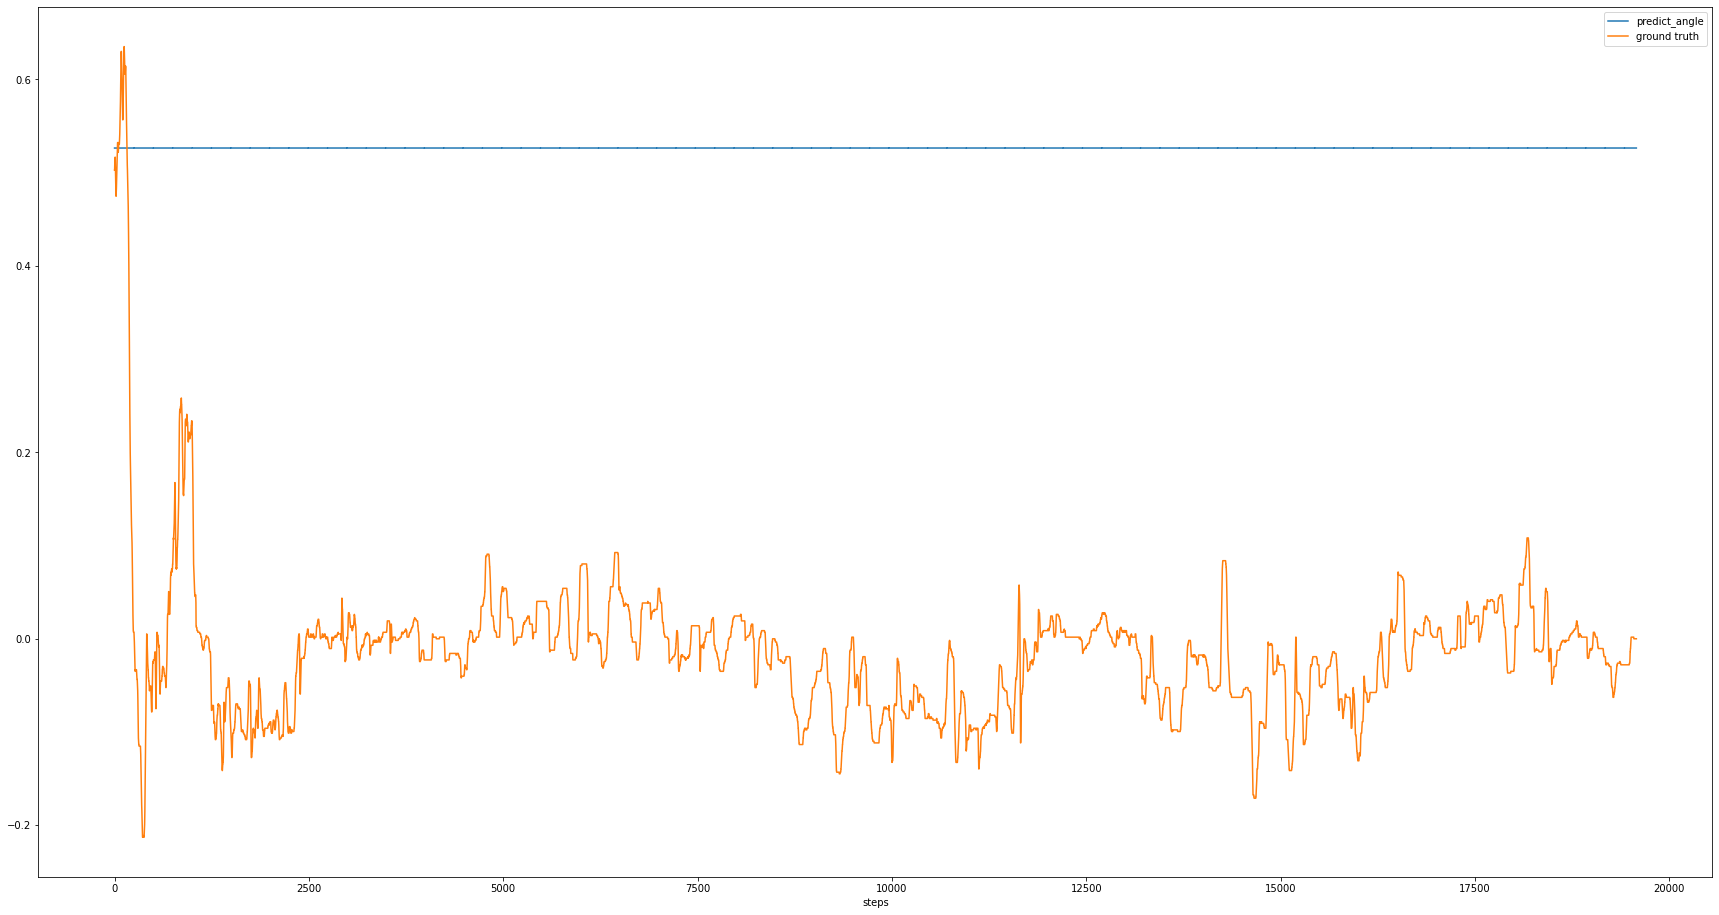

In [41]:
plot.figure(figsize=(30,16))
plot.plot(range(0,len(outputs_test)), outputs_test,label='predict_angle')
plot.plot(range(0,len(outputs_test)), test_label,label='ground truth')
plot.xlabel("steps")
plot.legend()